In [146]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, AveragePooling2D
from tensorflow.keras.models import Model

# others
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

In [147]:
plt.style.use('ggplot')

## CNN as classifier

We are going to built a CNN to receive the remote sensing data as input and the point measurements in binary form (Rain/No rain) as output. We are going to test it on the best-performing station in the region, the Tara station.

The first step is to load the satellite-based and ground measured datasets:

In [57]:
# load the 3x3 dataset

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

sat = pd.read_csv(folder+'TARAtable9.csv', index_col=0)

# get some basic info on the dataset
print(f'Dataset info')
print(f'---' * 10)
sat.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset info
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 13515 entries, 1980-01-01 to 2016-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpperLeft[mm]     13515 non-null  float64
 1   UpperCenter[mm]   13515 non-null  float64
 2   UpperRight[mm]    13515 non-null  float64
 3   MiddleLeft[mm]    13515 non-null  float64
 4   MiddleCenter[mm]  13515 non-null  float64
 5   MiddleRight[mm]   13515 non-null  float64
 6   LowerLeft[mm]     13515 non-null  float64
 7   LowerCenter[mm]   13515 non-null  float64
 8   LowerRight[mm]    13515 non-null  float64
dtypes: float64(9)
memory usage: 1.0+ MB


In [58]:
sat = sat.index

print(f'Dataset index')
print(f'---' * 10)

sat

Dataset index
------------------------------


Index(['1980-01-01', '1980-01-02', '1980-01-03', '1980-01-04', '1980-01-05',
       '1980-01-06', '1980-01-07', '1980-01-08', '1980-01-09', '1980-01-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', name='Date', length=13515)

In [59]:
# load the 64x64 dataset

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

sat64 = pd.read_csv(folder+'TARA64x64TABLE.csv', delimiter=' ', header=None)

# get some basic info on the dataset
print(f'Dataset info')
print(f'---' * 10)
sat64.info()

Mounted at /content/gdrive
Dataset info
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13515 entries, 0 to 13514
Columns: 4096 entries, 0 to 4095
dtypes: float64(4096)
memory usage: 422.3 MB


In [60]:
print(f'Dataset shape')
print(f'---' * 10)

sat64.shape

Dataset shape
------------------------------


(13515, 4096)

In [61]:
# date index to the 64x64 table

sat64.index = sat

# check the new dataset

# print(f'Dataset')
# print(f'---' * 10)
# sat64

Load the point measurements time-series:

In [62]:
gauge = pd.read_csv(folder+'stationTARA.csv', index_col=0)

# get some basic info on the dataset
print(f'Dataset info')
print(f'---' * 10)
gauge.info()

Dataset info
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3181 entries, 2004-05-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R[mm]   3181 non-null   float64
dtypes: float64(1)
memory usage: 49.7+ KB


In [63]:
# print(f'Point measurements')
# print(f'---' * 10)

# gauge

Next, we are going to create the training dataset for the overlapping years:

In [64]:
# merge the dataframes

df = gauge.merge(sat64, how='left', left_on=gauge.index, right_on=sat64.index)
df.rename(columns = {'key_0': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)

df = df.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

df.index = pd.to_datetime(df.index, errors='coerce')

# get some basic info on the merged dataframe
print(f'Dataset info')
print(f'---' * 10)
df.info()

Dataset info
------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2936 entries, 2004-05-01 to 2016-12-31
Columns: 4097 entries, R[mm] to 4095
dtypes: float64(4097)
memory usage: 91.8 MB


In [65]:
# check the final dataset

print(f'Final dataset')
print(f'---' * 10)

df

Final dataset
------------------------------


,R[mm],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.82,1.11,2.00,2.44,3.08,3.17,3.49,4.06,4.01,4.42,4.05,3.56,2.64,2.37,1.99,0.93,0.83
2004-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2004-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2004-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.7,2.34,2.18,1.39,1.51,1.8,1.94,2.11,1.77,1.52,1.90,1.73,1.15,1.08,1.04,0.59,0.49,0.28,0.27,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.26,0.58,0.85,0.76,0.48,0.55,0.24,0.45,0.81,1.14,0.82
2004-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.26,0.00,0.0,0.00,0.00,0.00,0.00,0.02,0.18,0.17,0.17,0.17,0.23,0.23,0.47,0.70,1.23,1.53,2.83,3.32,3.71,4.00,2.83,2.86,3.23,3.78,4.73,5.91,9.03,7.64,8.66,7.36,5.75,7.04,2.51,3.93,2.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Time to assess the match between the satellite-based values and the gauge observations:

### 1. Pearson's correlation

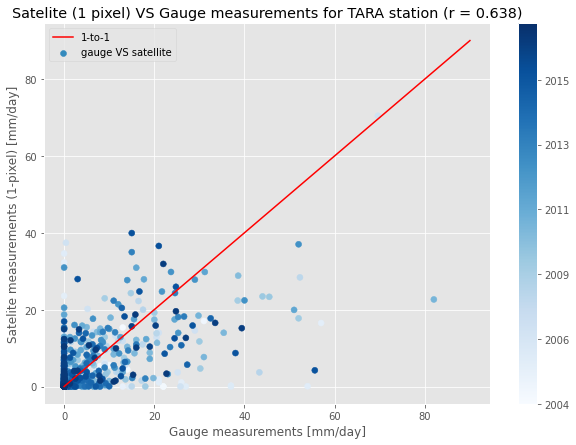

In [66]:
# correlation estimation

ind_pixel = 2081  # index of the pixel closest to the station
rho = df['R[mm]'].corr(df[ind_pixel])

# plot pixel values VS point measurements

plt.figure(figsize=(10, 7))

plt.scatter(df['R[mm]'], df[ind_pixel], c=range(len(df.index)), cmap="Blues", label='gauge VS satellite')
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r', label='1-to-1')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = df.index.year[np.arange(0, len(df), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)

plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')
plt.legend()
plt.title(f'Satelite (1 pixel) VS Gauge measurements for TARA station (r = {rho:.3f})');

### 2. Hits and misses

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [68]:
thr = 1.0  # mm/day, threshold between rainy and wet days

# create a dataset for the binary variables

TARAtrain = pd.DataFrame()

# binary values

TARAtrain['gauge'] = df['R[mm]']
TARAtrain['gauge'][df['R[mm]'] < thr] = 'No Rain'
TARAtrain['gauge'][df['R[mm]'] >= thr] = 'Rain'

TARAtrain['satellite'] = df[ind_pixel]
TARAtrain['satellite'][df[ind_pixel] < thr] = 'No Rain'
TARAtrain['satellite'][df[ind_pixel] >= thr] = 'Rain'

# TARAtrain.head(70)

In [69]:
# hits and misses

hits = len(np.where((TARAtrain['satellite'] == 'Rain') & (TARAtrain['gauge'] == 'Rain'))[0])
FalseAlarms = len(np.where((TARAtrain['satellite'] == 'Rain') & (TARAtrain['gauge'] == 'No Rain'))[0])
misses = len(np.where((TARAtrain['satellite'] == 'No Rain') & (TARAtrain['gauge'] == 'Rain'))[0])
TrueNegatives = len(np.where((TARAtrain['satellite'] == 'No Rain') & (TARAtrain['gauge'] == 'No Rain'))[0])

POD = hits / (hits + misses)
SR = hits / (hits + FalseAlarms)
FBias = (hits + FalseAlarms) / (hits + misses)
TS = hits / (hits + misses + FalseAlarms)


# print scores
print(f'Probability Of Detection: {POD:.2f}')
print(f'Success Ratio: {SR:.2f}')
print(f'Frequency Bias: {FBias:.2f}')
print(f'Threat Score: {TS:.2f}')

Probability Of Detection: 0.79
Success Ratio: 0.48
Frequency Bias: 1.63
Threat Score: 0.43



               precision    recall  f1-score   support

     No Rain       0.89      0.97      0.93      2386
        Rain       0.79      0.48      0.60       550

    accuracy                           0.88      2936
   macro avg       0.84      0.73      0.76      2936
weighted avg       0.87      0.88      0.87      2936



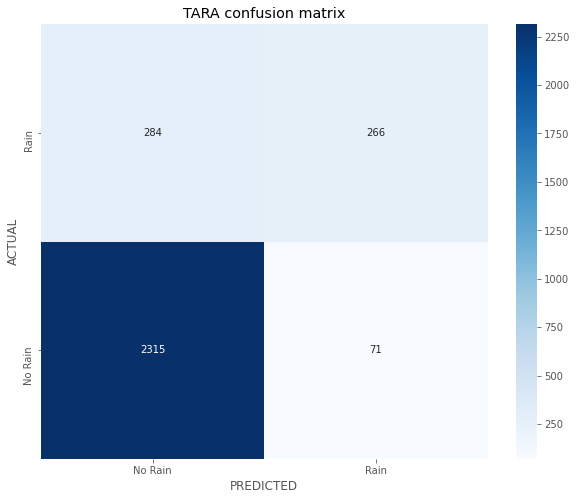

In [70]:
# confusion matrix

conf_matrix = []

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(np.array(TARAtrain['satellite']), TARAtrain['gauge']))
print('\n', classification_report(np.array(TARAtrain['satellite']), TARAtrain['gauge'], target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('TARA confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

### 3. Histogram matching

### 4. Double mass curves

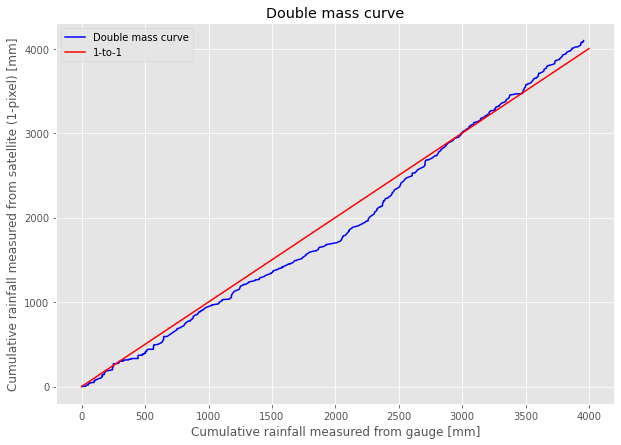

In [71]:
# visualization using double mass analysis

r = np.zeros(len(df['R[mm]']))
s = np.zeros(len(df[ind_pixel]))

for i in range(1, len(df['R[mm]'])):
  r[i] = r[i-1] + df['R[mm]'][i]
  s[i] = s[i-1] + df[ind_pixel][i]


# plot pixel values VS point measurements

plt.figure(figsize=(10, 7))

plt.plot(r, s, 'b', label='Double mass curve')
plt.plot(np.linspace(0, 4000, 2), np.linspace(0, 4000, 2), 'r', label='1-to-1')

plt.ylabel('Cumulative rainfall measured from satellite (1-pixel) [mm]')
plt.xlabel('Cumulative rainfall measured from gauge [mm]')
plt.legend()
plt.title('Double mass curve');

## Now let's try to build a CNN as a classifier for wet and dry days.

First we have to transform the labels to binary form, assumming a wet/dry day throshold of 1 mm/day:

In [72]:
thr = 1.0  # mm/day, threshold between rainy and wet days

# binary values

df['Rain'] = df['R[mm]']
df['Rain'][df['R[mm]'] < thr] = 0.0
df['Rain'][df['R[mm]'] >= thr] = 1.0

# we will not need the 'R[mm]' column any more

df.drop(['R[mm]'], axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.82,1.11,2.00,2.44,3.08,3.17,3.49,4.06,4.01,4.42,4.05,3.56,2.64,2.37,1.99,0.93,0.83,0.0
2004-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2004-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2004-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.34,2.18,1.39,1.51,1.8,1.94,2.11,1.77,1.52,1.90,1.73,1.15,1.08,1.04,0.59,0.49,0.28,0.27,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.26,0.58,0.85,0.76,0.48,0.55,0.24,0.45,0.81,1.14,0.82,0.0
2004-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.26,0.00,0.0,0.00,0.00,0.00,0.00,0.02,0.18,0.17,0.17,0.17,0.23,0.23,0.47,0.70,1.23,1.53,2.83,3.32,3.71,4.00,2.83,2.86,3.23,3.78,4.73,5.91,9.03,7.64,8.66,7.36,5.75,7.04,2.51,3.93,2.41,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [73]:
# training, validation and test datasets

from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(df.drop(['Rain'], axis=1), df['Rain'], test_size=0.15, random_state=42)
x_tra, x_tst, y_tra, y_tst = train_test_split(x_tra, y_tra, test_size=len(x_val), random_state=42)

for name, x in zip(['Training','Validation', 'Training'], [x_tra, x_val, x_tst]):
  print(f'The {name} dataset is {len(x)} rows long.')

The Training dataset is 2054 rows long.
The Validation dataset is 441 rows long.
The Training dataset is 441 rows long.


In [74]:
# expand dimension of the dataset, min_ndim=4

x_tra = x_tra.to_numpy()
x_tra = np.reshape(x_tra, (len(x_tra), 64, 64))  # is the reshape correct?

x_val = x_val.to_numpy()
x_val = np.reshape(x_val, (len(x_val), 64, 64))

x_tst = x_tst.to_numpy()
x_tst = np.reshape(x_tst, (len(x_tst), 64, 64))

print(x_tra.shape)

(2054, 64, 64)


In [75]:
# expand dimension of the dataset, min_ndim=4

x_tra = np.expand_dims(x_tra, -1)
x_val = np.expand_dims(x_val, -1)
x_tst = np.expand_dims(x_tst, -1)

print(x_tra.shape)

(2054, 64, 64, 1)


# Time to test different CNN architectures

### 1. First CNN classifier model

In [105]:
# create first model

i = Input(shape=x_tra[0].shape, name='Input')
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same', name='Convolutional1')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu', padding='same', name='Convolutional2')(x)
x = Conv2D(64, (3,3), strides=2, activation='relu', padding='same', name='Convolutional3')(x)
x = Flatten(name='Flatten')(x)
x = Dense(256, activation='relu', name='Hidden')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

model = Model(i, x)

# model summary
print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
Convolutional1 (Conv2D)      (None, 32, 32, 32)        320       
_________________________________________________________________
Convolutional2 (Conv2D)      (None, 16, 16, 64)        18496     
_________________________________________________________________
Convolutional3 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
Flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
Hidden (Dense)               (None, 256)               1048832   
_________________________________________________________________
Output (Dense)               (None, 1)                 257

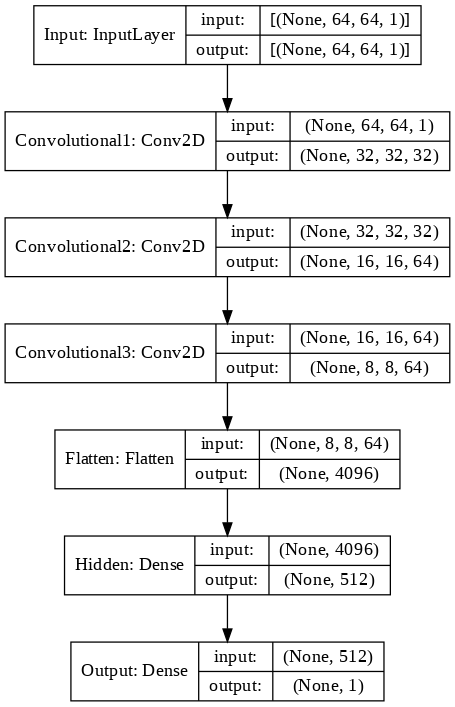

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=92)

In [106]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = model.fit(x_tra, y_tra, verbose = 1, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
65/65 [==============================] - 5s 71ms/step - loss: 0.4161 - accuracy: 0.8665 - auc: 0.6863 - val_loss: 0.3697 - val_accuracy: 0.8821 - val_auc: 0.9189
Epoch 2/10
65/65 [==============================] - 4s 66ms/step - loss: 0.2643 - accuracy: 0.9016 - auc: 0.8796 - val_loss: 0.2304 - val_accuracy: 0.8912 - val_auc: 0.9396
Epoch 3/10
65/65 [==============================] - 4s 67ms/step - loss: 0.2270 - accuracy: 0.9033 - auc: 0.9212 - val_loss: 0.2086 - val_accuracy: 0.9002 - val_auc: 0.9436
Epoch 4/10
65/65 [==============================] - 4s 66ms/step - loss: 0.1961 - accuracy: 0.9295 - auc: 0.9202 - val_loss: 0.1949 - val_accuracy: 0.9206 - val_auc: 0.9425
Epoch 5/10
65/65 [==============================] - 4s 65ms/step - loss: 0.1400 - accuracy: 0.9423 - auc: 0.9625 - val_loss: 0.2345 - val_accuracy: 0.9116 - val_auc: 0.9108
Epoch 6/10
65/65 [==============================] - 4s 65ms/step - loss: 0.0994 - accuracy: 0.9656 - auc: 0.9776 - val_loss: 0.2676 - v

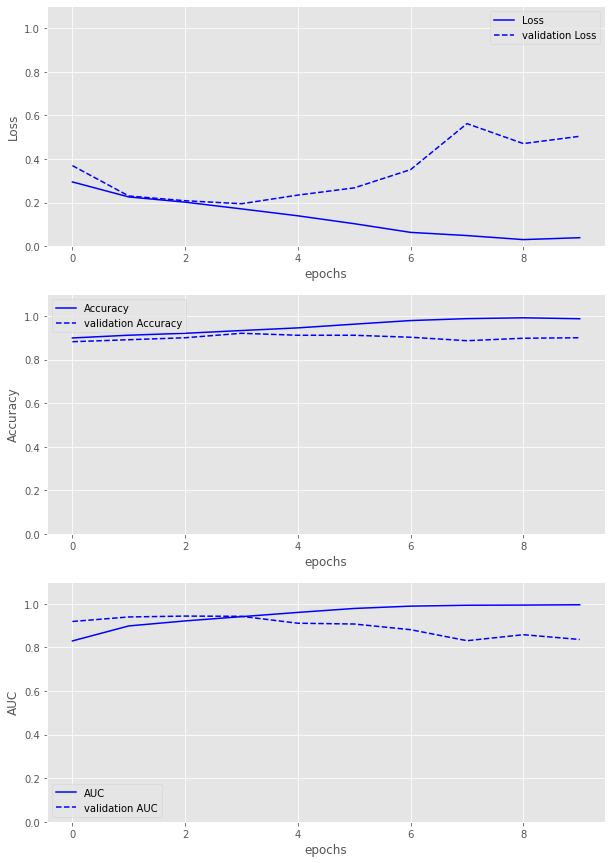

In [107]:
# plot results
f, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend()
ax[0].set_ylim(0, 1.1)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0, 1.1)

ax[2].plot(r_CNN.history['auc'], label = 'AUC', color = 'b')
ax[2].plot(r_CNN.history['val_auc'], label = 'validation AUC', color = 'b', ls= '--')
ax[2].legend()
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('AUC')
ax[2].set_ylim(0, 1.1);

### Model evaluation:

In [108]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = model.evaluate(x_tst, y_tst, batch_size=5)

print(' ')
print("Test loss:", results[0])
print(' ')
print("Test accuracy:", results[1])
print(' ')
print("Test AUC:", results[2])

Evaluate on test data
------------------------------
89/89 [==============================] - 0s 5ms/step - loss: 0.6128 - accuracy: 0.8730 - auc: 0.7903
 
Test loss: 0.6127829551696777
 
Test accuracy: 0.8730158805847168
 
Test AUC: 0.7903324961662292


### ROC curve:

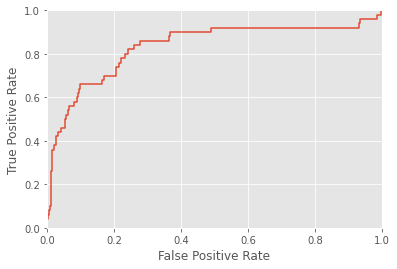

In [95]:
from sklearn.metrics import roc_curve, roc_auc_score

# # predict using the trained model and the test input

# y_hat = model.predict(x_tst)

# fpr , tpr , thresholds = roc_curve(y_tst , y_hat)

# # plot ROC

# plt.plot(fpr, tpr) 
# plt.axis([0, 1, 0, 1]) 
# plt.xlabel('False Positive Rate') 
# plt.ylabel('True Positive Rate') 
# plt.title('ROC curve')
# plt.show();

### 2. Second CNN classifier model

The first model reported increasing validation loss after a certain number of epochs, while keeping the validation accuracy constant. We will attempt to improve that using dropout.

In [150]:
# create second model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(32, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(32, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
x = AveragePooling2D(name='AveragePooling_1')(x)  # probably better than Max pooling

x = Conv2D(64, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(64, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
x = AveragePooling2D(name='AveragePooling_2')(x)

x = Conv2D(128, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(128, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
x = AveragePooling2D(name='AveragePooling_3')(x)

x = Conv2D(256, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_D1')(x)
x = Conv2D(256, (4,4), strides=1, activation='relu', padding='same', name='Convolutional_D2')(x)
x = AveragePooling2D(name='AveragePooling_4')(x)

x = Flatten(name='Flatten')(x)

x = Dropout(0.25, name='Dropout1')(x)
x = Dense(256, activation='relu', name='Hidden')(x)

x = Dropout(0.25, name='Dropout2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

model = Model(i, x)

# model summary
print('Model summary')
print("---" * 10)
print(model.summary())

Model summary
------------------------------
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 64, 64, 32)        544       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 64, 64, 32)        16416     
_________________________________________________________________
AveragePooling_1 (AveragePoo (None, 32, 32, 32)        0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 32, 32, 64)        32832     
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 32, 32, 64)        65600     
_________________________________________________________________
AveragePoolin

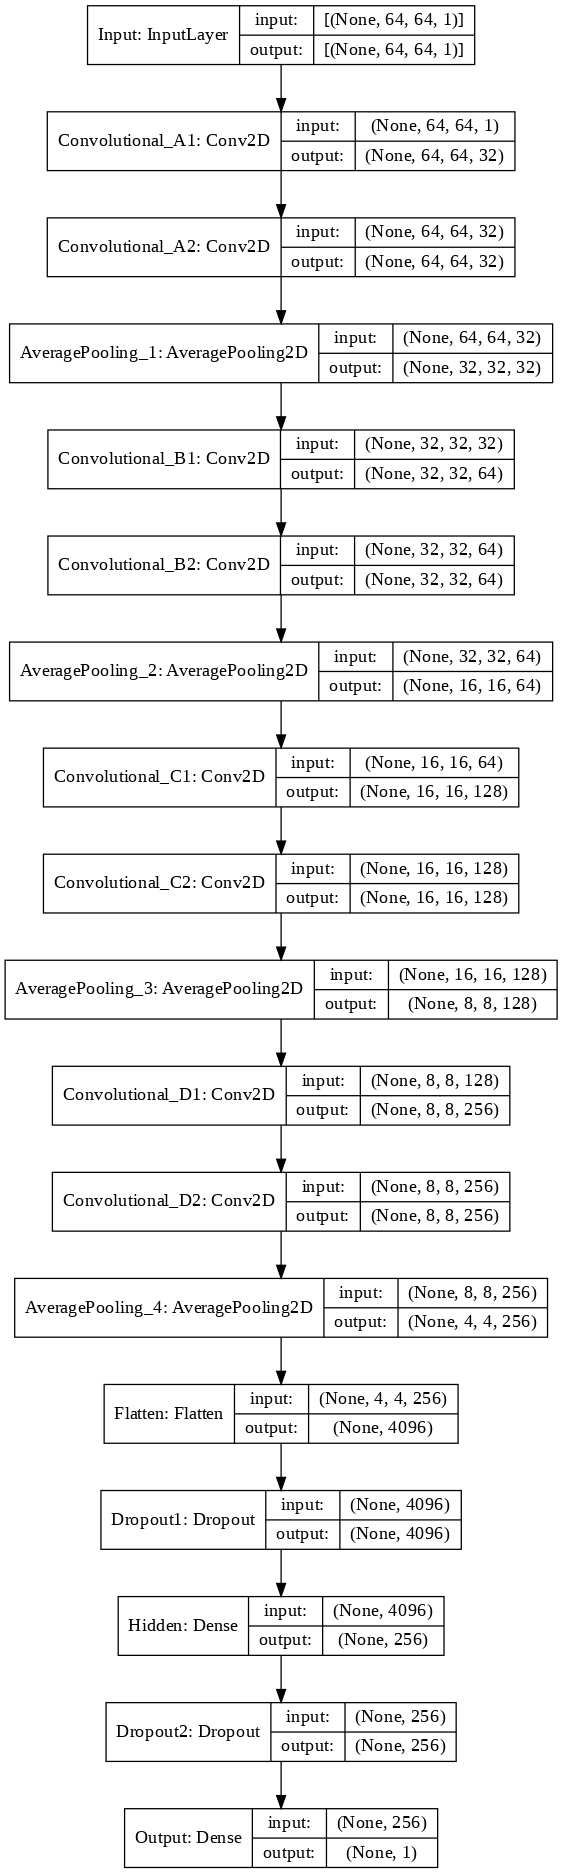

In [151]:
plot_model(model, show_shapes=True, dpi=92)

In [152]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = model.fit(x_tra, y_tra, verbose = 1, validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
65/65 [==============================] - 134s 2s/step - loss: 0.4707 - accuracy: 0.8594 - auc: 0.6335 - val_loss: 0.2369 - val_accuracy: 0.8866 - val_auc: 0.9258
Epoch 2/20
65/65 [==============================] - 132s 2s/step - loss: 0.2579 - accuracy: 0.8917 - auc: 0.8763 - val_loss: 0.2193 - val_accuracy: 0.8821 - val_auc: 0.9281
Epoch 3/20
65/65 [==============================] - 131s 2s/step - loss: 0.2315 - accuracy: 0.8967 - auc: 0.9018 - val_loss: 0.2343 - val_accuracy: 0.8934 - val_auc: 0.9256
Epoch 4/20
65/65 [==============================] - 133s 2s/step - loss: 0.3004 - accuracy: 0.8939 - auc: 0.8370 - val_loss: 0.2587 - val_accuracy: 0.8889 - val_auc: 0.9253
Epoch 5/20
65/65 [==============================] - 133s 2s/step - loss: 0.2336 - accuracy: 0.9060 - auc: 0.9039 - val_loss: 0.2581 - val_accuracy: 0.9048 - val_auc: 0.9253
Epoch 6/20
65/65 [==============================] - 133s 2s/step - loss: 0.2293 - accuracy: 0.8981 - auc: 0.8960 - val_loss: 0.2075 - v

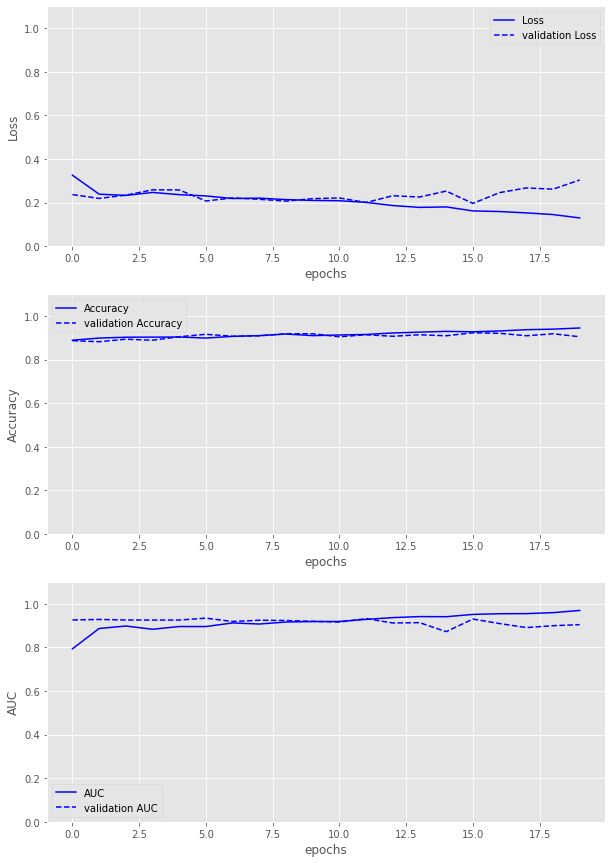

In [153]:
# plot results
f, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend()
ax[0].set_ylim(0, 1.1)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0, 1.1)

ax[2].plot(r_CNN.history['auc'], label = 'AUC', color = 'b')
ax[2].plot(r_CNN.history['val_auc'], label = 'validation AUC', color = 'b', ls= '--')
ax[2].legend()
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('AUC')
ax[2].set_ylim(0, 1.1);

In [154]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = model.evaluate(x_tst, y_tst, batch_size=5)

print(' ')
print("Test loss:", results[0])
print(' ')
print("Test accuracy:", results[1])
print(' ')
print("Test AUC:", results[2])

Evaluate on test data
------------------------------
89/89 [==============================] - 7s 77ms/step - loss: 0.3417 - accuracy: 0.8980 - auc: 0.8405
 
Test loss: 0.34168562293052673
 
Test accuracy: 0.8979591727256775
 
Test AUC: 0.8405370116233826
